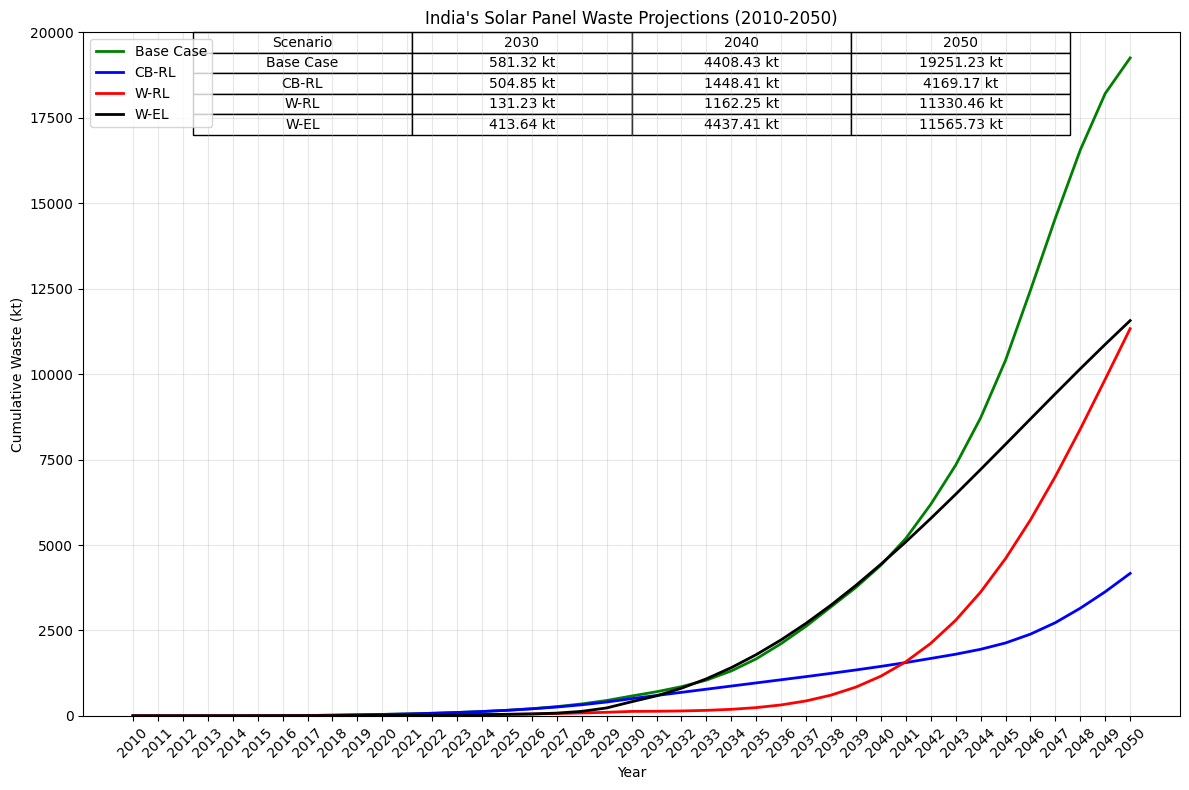

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

def calculate_eol_year(installation_year, dr):
    """Calculate End of Life year based on degradation rate"""
    performance = 100
    years = 0
    while performance >= 80:  # EOL when performance drops below 80%
        performance = performance - dr * performance
        years += 1
    return installation_year + years

class SolarWasteModel:
    def __init__(self):
        # Constants from Table 1
        self.MODULE_MASS = 65  # tonnes per MW
        self.T_H_COEFF = 0.002  # Transportation and handling coefficient (0.2%)
        self.PO_COEFF = 0.005  # Project operation coefficient (0.5%)
        self.BASE_DR = 0.014    # Base case degradation rate (1.4%)
        self.CB_RL_DR = 0.0082  # Regular loss degradation rate (0.82%)
        
    def generate_installation_data(self):
        """Generate installation data"""
        # Historical data 2014-2024 (MW)
        df = pd.read_csv("Data Set.csv")
        years = df['Year']
        cumulative_installations = df['Installed_Capacity_MW'].tolist()
        Annual_installations =[]
        historical_installations =[]
        past_years = np.arange(2010, 2014)
        for i in range(len(past_years) - 1):
            if i == 0:
                historical_installations.insert(0, cumulative_installations[0] / (1 + 0.44))
            historical_installations.insert(0,historical_installations[0] / (1 + 0.44))
        future_installations = []
        future_years = np.arange(2025, 2051)
        last_installation = cumulative_installations[-1]
        for i, _ in enumerate(future_years):
            if i < 6:
                next_value = last_installation * (1 + 0.23)
            else:
                next_value = last_installation
            future_installations.append(next_value)
            last_installation = next_value
        all_years = np.concatenate([past_years, years, future_years])
        all_installations = historical_installations + cumulative_installations + future_installations
        for i in range(1, len(all_installations)):
            Annual_installations.append(all_installations[i] - all_installations[i-1])
        Annual_installations.insert(0, all_installations[0])
        return pd.DataFrame({
            'Year': all_years,
            'Capacity_MW': all_installations,
            'Annual_installation': Annual_installations
        })
    def coefficient_based_waste(self, df, dr):
        """Calculate waste using coefficient-based approach"""
        waste_by_year = []
        total_waste = 0
        
        for year in df['Year']:
            year_waste = 0
            
            for install_year in range(2010, year + 1):
                idx = df['Year'] == install_year
                if not any(idx):
                    continue
                    
                capacity = df.loc[idx, 'Annual_installation'].values[0]
                mass = capacity * self.MODULE_MASS
                
                # Transportation and handling waste (first year only)
                if year == install_year:
                    th_waste = mass * self.T_H_COEFF
                    year_waste += th_waste
                
                # Project operation waste
                po_waste = mass * self.PO_COEFF
                year_waste += po_waste
                
                # End of Life waste
                eol_year = calculate_eol_year(install_year, dr)
                if year >= eol_year:
                    remaining_mass = mass - (mass * self.T_H_COEFF) - (mass * self.PO_COEFF * (eol_year - install_year))
                    if year == eol_year:
                        eol_waste = remaining_mass * 0.1  # 10% in first year
                    elif year == eol_year + 1:
                        eol_waste = remaining_mass * 0.15  # 15% in second year
                    elif year == eol_year + 2:
                        eol_waste = remaining_mass * 0.20  # 20% in third year
                    elif year == eol_year + 3:
                        eol_waste = remaining_mass * 0.25  # 25% in fourth year
                    elif year == eol_year + 4:
                        eol_waste = remaining_mass * 0.30  # 30% in fifth year
                    else:
                        eol_waste = 0
                    year_waste += eol_waste
            
            total_waste += year_waste
            waste_by_year.append(total_waste)
            
        return waste_by_year

    def weibull_waste(self, df, shape):
        """Calculate waste using Weibull approach"""
        waste = []
        total_waste = 0
        scale = 25  # Average lifetime
        
        for  t,year in enumerate(df['Year']):
            year_waste = 0
            failure_rate = weibull_min.cdf(t+1, shape, loc=16.3, scale=scale)
            
            for install_year in range(2010, year + 1):
                idx = df['Year'] == install_year
                
                if not any(idx):
                    continue
                    
                capacity = df.loc[idx, 'Annual_installation'].values[0]
                mass = capacity * self.MODULE_MASS
                year_waste += mass * failure_rate + mass * self.T_H_COEFF + mass * self.PO_COEFF
        
            
            total_waste = year_waste
            waste.append(total_waste)
        return waste

    def plot_results(self, df, base_case, cb_rl, w_rl, w_el):
        """Plot results for all scenarios"""
        plt.figure(figsize=(12, 8))
        
        # Convert to kilotonnesmake 
        base_case = [w/1000 for w in base_case]
        cb_rl = [w/1000 for w in cb_rl]
        w_rl = [w/1000 for w in w_rl]
        w_el = [w/1000 for w in w_el]
        
        plt.plot(df['Year'], base_case, 'g-', label='Base Case', linewidth=2)
        plt.plot(df['Year'], cb_rl, 'b-', label='CB-RL', linewidth=2)
        plt.plot(df['Year'], w_rl, 'r-', label='W-RL', linewidth=2)
        plt.plot(df['Year'], w_el, 'k-', label='W-EL', linewidth=2)
        plt.xticks(df["Year"][::1], rotation=45)
        # Add reference points table
        table_data = {
            'Scenario': ['Base Case', 'CB-RL', 'W-RL', 'W-EL'],
            '2030': [base_case[20], cb_rl[20], w_rl[20], w_el[20]],
            '2040': [base_case[30], cb_rl[30], w_rl[30], w_el[30]],
            '2050': [base_case[40], cb_rl[-1], w_rl[-1], w_el[-1]]
        }
        
        plt.grid(True, alpha=0.3)
        plt.xlabel('Year')
        plt.ylabel('Cumulative Waste (kt)')
        plt.title('India\'s Solar Panel Waste Projections (2010-2050)')
        plt.legend()
        plt.ylim(0, 20000)
        
        # Add table to plot
        plt.table(cellText=[['Base Case', f'{base_case[20]:.2f} kt', f'{base_case[30]:.2f} kt', f'{base_case[-1]:.2f} kt'],
               ['CB-RL', f'{cb_rl[20]:.2f} kt', f'{cb_rl[30]:.2f} kt', f'{cb_rl[-1]:.2f} kt'],
               ['W-RL', f'{w_rl[20]:.2f} kt', f'{w_rl[30]:.2f} kt', f'{w_rl[-1]:.2f} kt'],
               ['W-EL', f'{w_el[20]:.2f} kt', f'{w_el[30]:.2f} kt', f'{w_el[-1]:.2f} kt']],
             colLabels=list(table_data.keys()),
             cellLoc='center',
             loc='top',
             bbox=[0.1, 0.85, 0.8, 0.15],
             colWidths=[0.15, 0.15, 0.15, 0.15])
        
        plt.tight_layout()
        plt.show()

# Run the model
model = SolarWasteModel()
df = model.generate_installation_data()
df.to_csv('installation_data.csv', index=False)
# Calculate waste for all scenarios
base_case = model.coefficient_based_waste(df, model.BASE_DR)
cb_rl = model.coefficient_based_waste(df, model.CB_RL_DR)
w_rl = model.weibull_waste(df, 5.37)
w_el = model.weibull_waste(df, 2.49)

# Save the results to a new CSV file
results_df = pd.DataFrame({
    'Year': df['Year'],
    'Base_Case': base_case,
    'CB_RL': cb_rl,
    'W_RL': w_rl,
    'W_EL': w_el
})

results_df.to_csv('solar_waste_projections.csv', index=False)
# Plot results
model.plot_results(df, base_case, cb_rl, w_rl, w_el)